In [265]:
import tensorflow as tf
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import random

In [266]:
df = pd.read_csv('./Fish.csv')
df = df.sample(frac=1, random_state=1).reset_index(drop=True)
df.head()

,Species,Weight,Length1,Length2,Length3,Height,Width
0,Bream,1000.0,33.5,37.0,42.6,18.9570,6.6030
1,Roach,120.0,19.4,21.0,23.7,6.1146,3.2943
2,Bream,600.0,29.4,32.0,37.2,14.9544,5.1708
3,Perch,130.0,20.5,22.5,24.0,5.8560,3.6240
4,Perch,85.0,18.2,20.0,21.0,5.0820,2.7720


In [267]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159 entries, 0 to 158
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Species  159 non-null    object 
 1   Weight   159 non-null    float64
 2   Length1  159 non-null    float64
 3   Length2  159 non-null    float64
 4   Length3  159 non-null    float64
 5   Height   159 non-null    float64
 6   Width    159 non-null    float64
dtypes: float64(6), object(1)
memory usage: 8.8+ KB


In [268]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder

class Preprocess:
    def __init__(self, train, test):
        self.train = train
        self.test = test
        self.encoder = OneHotEncoder()
        self.scalar = StandardScaler()
    
    def preprocess_train(self):
        train_cat = self.train.select_dtypes(include='object')
        train_num = self.train.select_dtypes(exclude='object')

        train_cat = self.encoder.fit_transform(train_cat).toarray()
        train_num = self.scalar.fit_transform(train_num)

        train_processed = np.concatenate([train_num, train_cat], axis=1)

        y_train = train_processed[:, 1].copy()
        y_train = y_train.reshape((y_train.shape[0], 1))
        X_train = np.delete(train_processed, obj=1, axis=1)

        return X_train, y_train
    
    def preprocess_test(self):
        test_cat = self.test.select_dtypes(include='object')
        test_num = self.test.select_dtypes(exclude='object')

        test_cat = self.encoder.transform(test_cat).toarray()
        test_num = self.scalar.transform(test_num)

        test_processed = np.concatenate([test_num, test_cat], axis=1)

        y_test = test_processed[:, 1].copy()
        y_test = y_test.reshape((y_test.shape[0], 1))
        X_test = np.delete(test_processed, obj=1, axis=1)

        return X_test, y_test

In [269]:
def relu(z):
    return tf.math.maximum(0, z)

In [270]:
def linear(X, W, b):
    return (X @ W) + b

In [271]:
def compute_loss(y_hat, y):
    return tf.reduce_mean((y_hat - y) ** 2, axis=0)

In [272]:
train, test = df.iloc[:-30], df.iloc[-30:]

In [273]:
preprocess = Preprocess(train, test)
X_train, y_train = preprocess.preprocess_train()

In [274]:
input_size = X_train.shape[1]
output_size = 1

In [275]:
layer0, layer1 = 50, 100

In [276]:
factor = 0.01

In [277]:
W0 = tf.Variable(np.random.rand(input_size, layer0) * factor)
W1 = tf.Variable(np.random.rand(layer0, layer1) * factor)
W2 = tf.Variable(np.random.rand(layer1, output_size) * factor)
b0 = tf.Variable(np.zeros(layer0))
b1 = tf.Variable(np.zeros(layer1))
b2 = tf.Variable(np.zeros(output_size))

In [278]:
learning_rate = 1e-2
epochs = 1000
batch_size = X_train.shape[0]

In [279]:
class Model:
    def __init__(self):
        pass
    
    def initialization(self, factor):
        self.W0 = tf.Variable(np.random.rand(input_size, layer0) * factor)
        self.W1 = tf.Variable(np.random.rand(layer0, layer1) * factor)
        self.W2 = tf.Variable(np.random.rand(layer1, output_size) * factor)
        self.b0 = tf.Variable(np.zeros(layer0))
        self.b1 = tf.Variable(np.zeros(layer1))
        self.b2 = tf.Variable(np.zeros(output_size))
    
    def train(self):
        losses = []
        for _ in tqdm(range(epochs)):
            with tf.GradientTape() as tape:
                tape.watch([self.W0, self.W1, self.W2, self.b0, self.b1, self.b2])
                
                indexes = random.sample(range(len(X_train)), batch_size)
                X_batch = X_train[indexes]
                y_batch = y_train[indexes]

                h0 = relu(linear(X_batch, self.W0, self.b0))
                h1 = relu(linear(h0, self.W1, self.b1))
                y_hat = linear(h1, self.W2, self.b2)

                loss = compute_loss(y_hat, y_batch)
            
            grad = tape.gradient(loss, {
                'W0' : self.W0,
                'W1' : self.W1,
                'W2' : self.W2,
                'b0' : self.b0,
                'b1' : self.b1,
                'b2' : self.b2
            })

            self.W0 = self.W0 - learning_rate * grad['W0']
            self.W1 = self.W1 - learning_rate * grad['W1']
            self.W2 = self.W2 - learning_rate * grad['W2']
            self.b0 = self.b0 - learning_rate * grad['b0']
            self.b1 = self.b1 - learning_rate * grad['b1']
            self.b2 = self.b2 - learning_rate * grad['b2']
            losses.append(loss)
        return losses

100%|██████████| 1000/1000 [00:10<00:00, 92.90it/s]


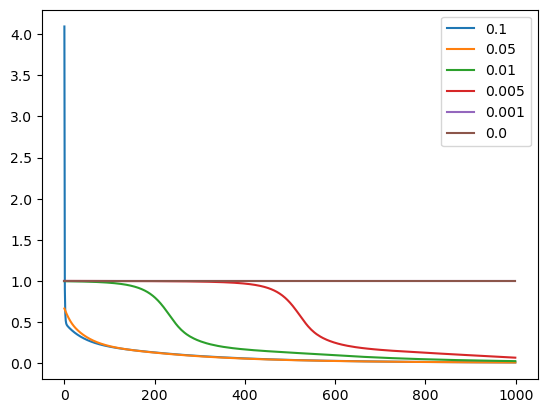

In [280]:
model = Model()
factors = [0.1, 0.05, 0.01, 0.005, 0.0]
for factor in factors:
    model.initialization(factor)
    losses = model.train()
    plt.plot(losses)
plt.legend([str(factor) for factor in factors])
plt.show()